# **Experiment - 8**

# **variational-autoencoders**

‎
‎
‎
‎
‎
‎
‎ ‎
‎

‎











# An Introduction to Variational Autoencoders

# Imports

In [ ]:
# For working with and visualizing the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For training the VAE
import tensorflow as tf

# For creating interactive widgets
import ipywidgets as widgets
from IPython.display import display

2024-05-22 06:28:22.848294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Load the data from a .csv file
pixel_data = pd.read_csv('/workspace/Bootcamp/data/age_gender.csv')['pixels']

In [ ]:
# Shuffle the data
pixel_data = pixel_data.sample(frac=1.0, random_state=1)
# Convert the data into a NumPy array
pixel_data = pixel_data.apply(lambda x: np.array(x.split(" "), dtype=np.int))
pixel_data = np.stack(np.array(pixel_data), axis=0)
# Rescale pixel values to be between 0 and 1
pixel_data = pixel_data * (1./255)

/tmp/ipykernel_92174/3099532490.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pixel_data = pixel_data.apply(lambda x: np.array(x.split(" "), dtype=np.int))


In [ ]:
# The data is now a NumPy array of 23705 images.
# we are working with 48x48x1 images)
pixel_data.shape

(23705, 2304)

# Building the VAE  
  
We need to create a custom Sampling layer to sample the latent variables from a normal distribution with mean and variance given by the encoder.

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs  # Unpack the inputs into mean and log-variance
        batch = tf.shape(z_mean)[0]  # Get the batch size
        dim = tf.shape(z_mean)[1]  # Get the dimensionality of the latent space
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))  # Sample from standard normal distribution
        return epsilon * tf.exp(z_log_var * 0.5) + z_mean  # Apply the reparameterization trick


In [ ]:
def build_vae(num_pixels, num_latent_vars=3):

    # Encoder
    encoder_inputs = tf.keras.Input(shape=(num_pixels,))  # Input layer for the encoder
    x = tf.keras.layers.Dense(512, activation='relu')(encoder_inputs)  # First dense layer with 512 units and ReLU activation
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # Second dense layer with 128 units and ReLU activation
    x = tf.keras.layers.Dense(32, activation='relu')(x)  # Third dense layer with 32 units and ReLU activation
    z_mean = tf.keras.layers.Dense(num_latent_vars)(x)  # Dense layer for the mean of the latent variables
    z_log_var = tf.keras.layers.Dense(num_latent_vars)(z_mean)  # Dense layer for the log-variance of the latent variables
    z = Sampling()([z_mean, z_log_var])  # Sampling layer to sample the latent variables using the reparameterization trick

    encoder = tf.keras.Model(inputs=encoder_inputs, outputs=z)  # Define the encoder model

    # Decoder
    decoder_inputs = tf.keras.Input(shape=(num_latent_vars,))  # Input layer for the decoder
    x = tf.keras.layers.Dense(32, activation='relu')(decoder_inputs)  # First dense layer with 32 units and ReLU activation
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # Second dense layer with 128 units and ReLU activation
    x = tf.keras.layers.Dense(512, activation='relu')(x)  # Third dense layer with 512 units and ReLU activation
    reconstruction = tf.keras.layers.Dense(num_pixels, activation='linear')(x)  # Output dense layer with 'num_pixels' units and linear activation

    decoder = tf.keras.Model(inputs=decoder_inputs, outputs=reconstruction)  # Define the decoder model

    # Full model
    model_inputs = encoder.input  # Inputs of the full VAE model are the inputs of the encoder
    model_outputs = decoder(encoder.output)  # Outputs of the full VAE model are the outputs of the decoder, given the encoder's output

    model = tf.keras.Model(inputs=model_inputs, outputs=model_outputs)  # Define the full VAE model

    # Compile model for training
    model.compile(
        optimizer='adam',  # Adam optimizer
        loss='mse'  # Mean Squared Error (MSE) loss function
    )

    # Return all three models
    return encoder, decoder, model  # Return the encoder, decoder, and full VAE models


In [ ]:
face_encoder, face_decoder, face_model = build_vae(num_pixels=2304, num_latent_vars=3)

2024-05-22 06:28:31.067844: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
print(face_encoder.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2304)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 512)                  1180160   ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  65664     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 32)                   4128      ['dense_1[0][0]']             
                                                                                              

In [ ]:
print(face_decoder.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_5 (Dense)             (None, 32)                128       
                                                                 
 dense_6 (Dense)             (None, 128)               4224      
                                                                 
 dense_7 (Dense)             (None, 512)               66048     
                                                                 
 dense_8 (Dense)             (None, 2304)              1181952   
                                                                 
Total params: 1252352 (4.78 MB)
Trainable params: 1252352 (4.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# Train the VAE  
  
We will use *pixel_data* as both the input to the model and the target to compare the output to.

In [ ]:
history = face_model.fit(
    pixel_data,
    pixel_data,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
593/593 [==============================] - 8s 12ms/step - loss: 0.0256 - val_loss: 0.0216
Epoch 2/100
593/593 [==============================] - 5s 9ms/step - loss: 0.0216 - val_loss: 0.0213
Epoch 3/100
593/593 [==============================] - 5s 9ms/step - loss: 0.0214 - val_loss: 0.0212
Epoch 4/100
593/593 [==============================] - 5s 9ms/step - loss: 0.0212 - val_loss: 0.0212
Epoch 5/100
593/593 [==============================] - 5s 9ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 6/100
593/593 [==============================] - 5s 9ms/step - loss: 0.0211 - val_loss: 0.0213
Epoch 7/100
593/593 [==============================] - 5s 9ms/step - loss: 0.0210 - val_loss: 0.0209
Epoch 8/100
593/593 [==============================] - 5s 9ms/step - loss: 0.0209 - val_loss: 0.0209
Epoch 9/100
593/593 [==============================] - 5s 9ms/step - loss: 0.0209 - val_loss: 0.0210
Epoch 10/100
593/593 [==============================] - 5s 9ms/step - loss: 0.0208 - val_l

# Image Reconstruction  
  
Let's see how the model does at reconstructing an image that it has already seen.

741/741 [==============================] - 1s 2ms/step


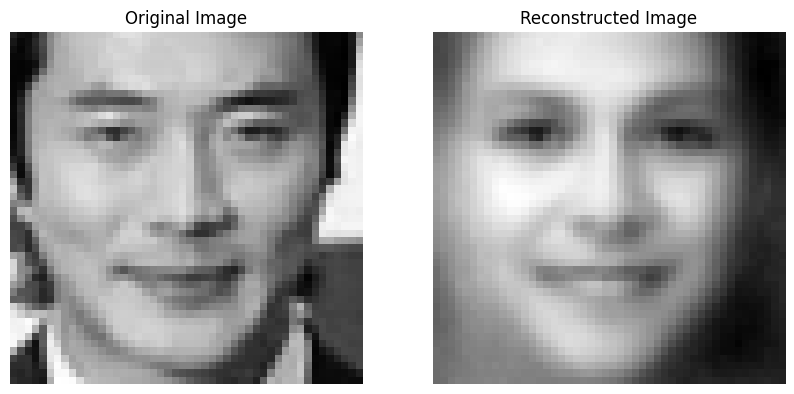

In [ ]:


i = 6

sample = np.array(pixel_data)[i].copy()
sample = sample.reshape(48, 48, 1)

reconstruction = face_model.predict(pixel_data)[i].copy()
reconstruction = reconstruction.reshape(48, 48, 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample, cmap='gray')
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(reconstruction, cmap='gray')
plt.axis('off')
plt.title("Reconstructed Image")

plt.show()

# Specify our own latent variable values  
  
Now let's see how we can use our own values to generate never-before-seen images.

In [ ]:
# A function to allow us to specify our own latent variable values and plot the constructed image
def generate_face_image(latent1, latent2, latent3):
    latent_vars = np.array([[latent1, latent2, latent3]])
    reconstruction = np.array(face_decoder(latent_vars))
    reconstruction = reconstruction.reshape(48, 48, 1)
    plt.figure()
    plt.imshow(reconstruction, cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
# Let's get the min and max for each slider on the interactive widget
latent1_min = np.min(face_encoder(pixel_data).numpy()[:, 0])
latent1_max = np.max(face_encoder(pixel_data).numpy()[:, 0])

latent2_min = np.min(face_encoder(pixel_data).numpy()[:, 1])
latent2_max = np.max(face_encoder(pixel_data).numpy()[:, 1])

latent3_min = np.min(face_encoder(pixel_data).numpy()[:, 2])
latent3_max = np.max(face_encoder(pixel_data).numpy()[:, 2])

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.13.1


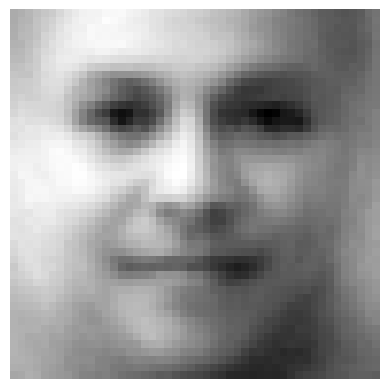

interactive(children=(FloatSlider(value=-0.6328935623168945, description='latent1', max=7.612391471862793, min…

<function __main__.generate_face_image(latent1, latent2, latent3)>

In [ ]:
# Create the interactive widget
face_image_generator = widgets.interact(
    generate_face_image,
    latent1=(latent1_min, latent1_max),
    latent2=(latent2_min, latent2_max),
    latent3=(latent3_min, latent3_max),
)

# Display the widget
display(face_image_generator)